In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ai_project
!pip install transformations
import torch
import torch.nn as nn
import numpy as np
#import data_loader
#import torch_se3
import time
#from params import par
from torch.autograd import Variable
from torch.nn.init import kaiming_normal_, orthogonal_
import torch_se3
import os

from torch.utils.data import Dataset, DataLoader


import transformations
import time
os.getcwd()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-83a5599ba09a>", line 4, in <module>
    get_ipython().magic('cd /content/drive/MyDrive/ai_project')
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-84>", line 2, in cd
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magics/osm.py

FileNotFoundError: ignored

In [ ]:
class Dict2Class(object):
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])
def angvel_skew_symm(w):
  wx = w[0]
  wy = w[1]
  wz = w[2]
  m = np.array([[0, -wx, -wy, -wz],
                [wx, 0, wz, -wy],
                [wy, -wz, 0, wx],
                [wz, wy, -wx, 0]])
  return m
class IMU_Dataset(Dataset):
  def __init__(self, seq_name, seq_len, overlap, add_bias=True):
    self.base_path = os.getcwd()
    self.seq_name = seq_name
    self.seq_len = seq_len
    self.overlap = overlap
    self.add_bias = add_bias
    self.biased_integrations = []

    if isinstance(seq_name, list):
      imu_data_dict = {"time": np.array([]),
                "acc": np.array([]),
                "gyro": np.array([])}
      gt_data_dict = {"time": np.array([]),
                "pos": np.array([]),
                "quat": np.array([]),
                "vel": np.array([])}

      self.imu_data = Dict2Class(imu_data_dict)
      self.gt_data = Dict2Class(gt_data_dict)

      self.dataset_boundaries = []
      for seq in seq_name:
        _imu_data, _gt_data = self.read_data(seq)

        self.imu_data.time = np.append(self.imu_data.time, _imu_data.time)
        self.imu_data.acc = np.append(self.imu_data.acc, _imu_data.acc).reshape(-1,3)
        self.imu_data.gyro = np.append(self.imu_data.gyro, _imu_data.gyro).reshape(-1,3)

        self.gt_data.time = np.append(self.gt_data.time, _gt_data.time)
        self.gt_data.pos = np.append(self.gt_data.pos, _gt_data.pos).reshape(-1,3)
        self.gt_data.vel = np.append(self.gt_data.vel, _gt_data.vel).reshape(-1,3)
        self.gt_data.quat = np.append(self.gt_data.quat, _gt_data.quat).reshape(-1,4)
        self.dataset_boundaries.append(len(self.imu_data.time))
      print(self.dataset_boundaries)

    else:
      self.imu_data, self.gt_data = self.read_data(self.seq_name)
      self.dataset_boundaries = [len(self.imu_data.time)]


  def read_data(self, seq_name):
    imu_timestamps = []
    imu_data = []
    imu_csv = open(os.path.join(self.base_path, 'euroc/' + seq_name + '/imu0/data.csv'), 'r')
    gt_csv = open(os.path.join(self.base_path, 'euroc/' + seq_name + '/state_groundtruth_estimate0/data.csv'), 'r')

    imu_data = {"time": np.array([],dtype=np.int),
                "acc": np.array([]),
                "gyro": np.array([])}
    gt_data = {"time": np.array([],dtype=np.int),
                "pos": np.array([]),
                "quat": np.array([]),
                "vel": np.array([])}

    imu_csv.readline()  # skip header
    for line in imu_csv:
      line = line.split(",")
      timestamp = int(line[0])
      data = [float(line[i]) for i in range(1, len(line))]
      imu_data["time"] = np.append(imu_data["time"], timestamp)
      imu_data["gyro"] = np.append(imu_data["gyro"], data[0:3])
      imu_data["acc"] = np.append(imu_data["acc"], data[3:])

    imu_data["acc"] = imu_data["acc"].reshape(-1,3)
    imu_data["gyro"] = imu_data["gyro"].reshape(-1,3)


    gt_csv.readline()  # skip header
    for line in gt_csv:
      line = line.split(",")
      timestamp = int(line[0])
      data = [float(line[i]) for i in range(1, len(line))]
      gt_data["time"] = np.append(gt_data["time"], timestamp)
      gt_data["pos"] = np.append(gt_data["pos"], data[0:3])
      gt_data["quat"] = np.append(gt_data["quat"], data[3:7])
      gt_data["vel"] = np.append(gt_data["vel"], data[7:10])

    gt_data["pos"] = gt_data["pos"].reshape(-1,3)
    gt_data["quat"] = gt_data["quat"].reshape(-1,4)
    gt_data["vel"] = gt_data["vel"].reshape(-1,3)

    # Clip measurements with no ground truth at the start
    if (imu_data["time"][0] < gt_data["time"][0]):
      t_ref = gt_data["time"][0]
      min_offset_idx = np.argmin(np.abs(imu_data["time"] - t_ref))
      imu_data_aligned = {"time":imu_data["time"][min_offset_idx:],
                          "acc": imu_data["acc"][min_offset_idx:],
                          "gyro": imu_data["gyro"][min_offset_idx:]}
    else:
      raise NotImplementedError("ground truth data starts before imu. Implement this!!!!")

    # Clip measurements with no ground truth at the end
    if imu_data["time"][-1] > gt_data["time"][-1]:
      t_ref = gt_data["time"][-1]
      min_offset_idx = np.argmin(np.abs(imu_data_aligned["time"] - t_ref))
      imu_data_aligned = {"time":imu_data_aligned["time"][:min_offset_idx+1],
                          "acc": imu_data_aligned["acc"][:min_offset_idx+1],
                          "gyro": imu_data_aligned["gyro"][:min_offset_idx+1]}
    else:
      raise NotImplementedError("ground truth ends starts after imu. Implement this!!!!")
    gt_data_aligned = gt_data

    #### Uncomment this if frequency of imu measurements and ground truth are different

    # gt_data_aligned = {"time": np.array([],dtype=np.int),
    #                     "pos": np.array([]),
    #                     "quat": np.array([]),
    #                     "vel": np.array([])}

    # for imu_timestamp in imu_data_aligned["time"]:
    #   min_offset_idx = np.argmin(np.abs(gt_data["time"] - imu_timestamp))
    #   gt_data_aligned["time"] = np.append(gt_data_aligned["time"], gt_data["time"][min_offset_idx])
    #   gt_data_aligned["pos"] = np.append(gt_data_aligned["pos"], gt_data["pos"][min_offset_idx])
    #   gt_data_aligned["quat"] = np.append(gt_data_aligned["quat"], gt_data["quat"][min_offset_idx])
    #   gt_data_aligned["vel"] = np.append(gt_data_aligned["vel"], gt_data["vel"][min_offset_idx])

    # gt_data_aligned["pos"] = gt_data_aligned["pos"].reshape(-1,3)
    # gt_data_aligned["quat"] = gt_data_aligned["quat"].reshape(-1,4)
    # gt_data_aligned["vel"] = gt_data_aligned["vel"].reshape(-1,3)

    if len(imu_data_aligned["time"]) != len(gt_data_aligned["time"]):
      raise Exception("Number of imu measurements and ground truth are not same")

    # Convert times from nanosecond to seconds and start from 0
    imu_data_aligned["time"] = (imu_data_aligned["time"] - imu_data_aligned["time"][0]) / (10**9)
    gt_data_aligned["time"] = (gt_data_aligned["time"] - gt_data_aligned["time"][0]) / (10**9)

    imu_data_aligned = Dict2Class(imu_data_aligned)
    gt_data_aligned = Dict2Class(gt_data_aligned)

    return (imu_data_aligned, gt_data_aligned)



  def __len__(self):
    return int((len(self.imu_data.time) - self.seq_len- 1) / self.overlap)

  def __getitem__(self, idx):
    idx_seq_start = idx *  self.overlap
    for boundary in self.dataset_boundaries:
      if (abs(boundary - idx_seq_start - 1) <= self.seq_len) and (idx_seq_start < boundary):
        idx_seq_start = boundary - self.seq_len -1

    idx_seq_end = idx_seq_start+self.seq_len
    t_start = self.gt_data.time[idx_seq_start]
    t_end = self.gt_data.time[idx_seq_end]

    acc_noise_mean = 0
    gyro_noise_mean = 0
    acc_stddev = 0.005
    gyro_stddev = 0.001


    dt_ij = self.imu_data.time[idx_seq_end] - self.imu_data.time[idx_seq_start]


    T_k = transformations.quaternion_matrix(self.gt_data.quat[idx_seq_start])      # gt pose of body
    C_b_w = np.transpose(T_k[0:3, 0:3])

    g = 0
    for i in range(idx_seq_start, idx_seq_end):
      dt = self.gt_data.time[i+1] - self.gt_data.time[i]
      dt2 = dt * dt
      g += np.array([0,0,-9.81])*(dt2)

    gamma = C_b_w.dot(self.gt_data.pos[idx_seq_end] - self.gt_data.pos[idx_seq_start] - self.gt_data.vel[idx_seq_start] * dt_ij - 0.5*g)
    beta = C_b_w.dot(self.gt_data.vel[idx_seq_end] - self.gt_data.vel[idx_seq_start] - np.array([0,0,-9.81])*dt_ij)

    T_k = transformations.quaternion_matrix(self.gt_data.quat[idx_seq_end])      # gt pose of body
    C_k1 = T_k[0:3, 0:3]
    C = C_b_w.dot(C_k1)

    ### Get imu measurements
    # Create Gaussian Noise
    np.random.seed(idx)
    acc_added_noise = np.random.normal(acc_noise_mean, acc_stddev, self.imu_data.acc[idx_seq_start:idx_seq_end].shape)
    np.random.seed(idx+123456)
    gyro_added_noise = np.random.normal(gyro_noise_mean, gyro_stddev, self.imu_data.gyro[idx_seq_start:idx_seq_end].shape)

    imu_timestamps = self.imu_data.time[idx_seq_start:idx_seq_end].reshape(-1,1)
    raw_acc_data = self.imu_data.acc[idx_seq_start:idx_seq_end]
    raw_gyro_data = self.imu_data.gyro[idx_seq_start:idx_seq_end]

    noisy_acc_data = raw_acc_data + acc_added_noise
    noisy_gyro_data = raw_gyro_data + gyro_added_noise

    # calculate integrated biases
    i_gamma_noiseless = i_gamma_noisy = i_beta_noiseless = i_beta_noisy =  0
    C_noisy = C_noiseless= np.eye(3,3)
    q_noiseless = q_noisy = np.array([1.0,0.0,0.0,0.0])

    for i, (acc, gyro, noisy_acc, noisy_gyro) in enumerate(zip(raw_acc_data, raw_gyro_data, noisy_acc_data, noisy_gyro_data)):
      dt = self.imu_data.time[idx_seq_start+i+1] - self.imu_data.time[idx_seq_start+i]
      # Integrate measurements without noise
      i_beta_noiseless += C_noiseless.dot(acc)  * dt
      i_gamma_noiseless += C_noiseless.dot(acc) * dt**2
      q_noiseless += 0.5 * np.matmul(angvel_skew_symm(gyro), q_noiseless) * dt
      C_noiseless = transformations.quaternion_matrix(q_noiseless)[0:3,0:3]
      # Integrate measurements with noise
      i_beta_noisy += C_noisy.dot(noisy_acc) * dt
      i_gamma_noisy += C_noisy.dot(noisy_acc) * dt**2
      q_noisy += 0.5 * np.matmul(angvel_skew_symm(noisy_gyro), q_noisy) * dt
      C_noisy = transformations.quaternion_matrix(q_noisy)[0:3,0:3]

    beta_bias = i_beta_noisy - i_beta_noiseless
    gamma_bias = i_gamma_noisy - i_gamma_noiseless
    C_bias = C_noiseless.dot(C_noisy.T)

    self.biased_integrations.append([i_gamma_noisy, i_beta_noisy, C_noisy])
    imu_stacked = np.concatenate((imu_timestamps,
                                  noisy_gyro_data,
                                  noisy_acc_data), axis=1)

    return imu_stacked, np.expand_dims(gamma, 1), np.expand_dims(beta, 1), C,  np.expand_dims(gamma_bias,1), np.expand_dims(beta_bias,1), C_bias


# if __name__ == '__main__':
#   tr_dataset = IMU_Dataset("mh01", 10, 5)
#   tr_loader = DataLoader(
#         tr_dataset,
#         batch_size=32, #params["batch_size"],
#         #sampler = train_sampler,
#         shuffle=False,                                                          # Shuffle might be True !
#         num_workers= 4, #params["num_workers"],
#         pin_memory=True )
#   print(len(tr_dataset))


In [ ]:
param  = {
    'device': 'cpu',
    'input_size': 6,
    'hidden_size': 128,
    'num_layers': 1,
    'num_classes': 6,
    'batch_size': 32,
    'lr': 0.0001,
    'epoch': 20,
    'seq_len': 10,
    'num_workers': 2,
    'lambda': 100,
    'train_overlap': 5,
    'val_overlap': 10,
    'bias': True
}



In [ ]:
train_dataset_names = ["mh01","mh03", "mh05", "v102","v201","v203"]
val_dataset_names = ["mh02", "mh04", "v103", "v202", "v101"]
# train_dataset_names = ["mh01"]
# val_dataset_names = ["mh02"]
train_dataset = IMU_Dataset(train_dataset_names, param['seq_len'], param['train_overlap'])
val_dataset = IMU_Dataset(val_dataset_names, param['seq_len'], param['val_overlap'])


[36382, 62684, 84896, 101598, 123999, 146969]
[29993, 49746, 70678, 93769, 122481]


In [ ]:
class Huber_Loss(nn.Module):
  def __init__(self, delta=1.0, rotation=False):
    super(Huber_Loss, self).__init__()
    self.rotation = rotation
    self.delta = delta

  def forward(self, inputs, targets, bias=None):
    total_error = 0
    total_points = 0

    for i, n in enumerate(inputs[0]):
      total_points += 1
      if self.rotation == False:
        if bias is None:
          error = torch.linalg.norm(targets[i] - inputs[i])
        else:
          error = torch.linalg.norm(targets[i] - inputs[i] -bias[i])
      else:
        mm = torch.matmul
        #print(inputs[0].dtype, targets[0].dtype)
        #a = torch_se3.log_SO3(mm(inputs[i].transpose(-2,-1), targets[i]))
        #print(a.dtype)
        if bias is None:
          error = torch.linalg.norm(torch_se3.log_SO3(mm(inputs[i].transpose(-2,-1), targets[i])))
        else:
          C1 = mm(bias[i].transpose(-2,-1), inputs[i].transpose(-2,-1))
          C2 = mm(C1, targets[i])
          error = torch.linalg.norm(torch_se3.log_SO3(C2))

      if error <= self.delta:
        huber_error = 0.5 * (error**2)
      else:
        huber_error = self.delta * (error -  0.5*self.delta)

      total_error += huber_error

    huber = total_error / total_points
    return huber

L_rot = Huber_Loss(delta=1.0, rotation=True).to(param['device'])
L_v = Huber_Loss(delta=1.0).to(param['device'])
L_p = Huber_Loss(delta=1.0).to(param['device'])

# ALSO INCLUDE REGULARIZATION LOSS TERM !!!!
def L_d(meas, lstm_out):
  w_cl = lstm_out[:, :, 1:4]
  a_cl = lstm_out[:, :, 4:7]

  w_meas = meas[:, :, 1:4]
  a_meas = meas[:, :, 4:7]

  tmp_w = w_meas - w_cl
  tmp_a = a_meas - a_cl
  relu = torch.nn.ReLU()
  L_w = relu(torch.linalg.vector_norm(tmp_w, dim=-1) - param['lambda'])
  L_w = torch.sum(torch.sum(L_w, dim=-1) / param['seq_len'], dim=-1) / param['batch_size']

  L_a = relu(torch.linalg.vector_norm(tmp_a, dim=-1) - param['lambda'])
  L_a = torch.sum(torch.sum(L_a, dim=-1) / param['seq_len'], dim=-1) / param['batch_size']

  return L_w, L_a

In [ ]:
class Bi_LSTM(nn.Module):
  def __init__(self, param):
    super(Bi_LSTM, self).__init__()

    self.input_size = param['input_size']
    self.hidden_size = param['hidden_size']
    self.num_layers = param['num_layers']
    self.num_classes = param['num_classes']
    self.param = param
    self.LSTM = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(self.hidden_size*2, self.num_classes)

    self.reset_hidden_states()

  def reset_hidden_states(self, batch_size=32, zeros=True):
    if zeros:
      self.h = Variable(torch.zeros(self.num_layers*2, batch_size, self.hidden_size)).to(self.param['device'])
      self.c = Variable(torch.zeros(self.num_layers*2, batch_size, self.hidden_size)).to(self.param['device'])
      #print(self.h.size(), self.c.size())

    else:
      self.h = Variable(self.h.data).to(self.param['device'])
      #print(self.h.dtype)
      self.c = Variable(self.c.data).to(self.param['device'])
      #print(self.c.dtype)

  def forward(self, x):
    # Extract imu time data
    batch_size = x.size(0)
    seq_len = x.size(1)
    t = x[..., 0].view(batch_size, seq_len, 1)
    w = x[..., 1:4].view(batch_size, seq_len, 3)
    a = x[..., 4:7].view(batch_size, seq_len, 3)
    x = torch.cat((w, a), 2)
    out, (self.h, self.c) = self.LSTM(x, (self.h, self.c))
    # YOU NEED THE OUTPUTS OF ALL TIMESTEPS IN ORDER TO INTEGRATE THEM
    out = self.fc(out) #self.fc(out[:, -1, :])
    out = torch.cat((t, out), 2)
    return out



class IMU_Preprocess(nn.Module):
  def __init__(self, param):
    super(IMU_Preprocess, self).__init__()

    self.param = param
    # RNN block
    self.bi_lstm = Bi_LSTM(self.param)
    # RESET LSTM HIDDEN STATES TO ZERO
    self.bi_lstm.reset_hidden_states(batch_size=self.param['batch_size'], zeros=True)


  def forward(self, x):
    # Propagate through RNN block
    self.bi_lstm.reset_hidden_states(batch_size=self.param['batch_size'], zeros=False)        # Reset LSTM hidden states --> zeros=False ???
    out = self.bi_lstm(x)
    # Propagate through integration block
    gamma, beta, C = self.integration_block(out)

    return gamma, beta, C, out



  def integration_block(self, imu_cl):
    seq_len = imu_cl.size(1)
    num_batches = imu_cl.size(0)

    C_accum = torch.eye(3, 3, device=imu_cl.device).repeat(num_batches, 1, 1)
    gamma_accum = torch.zeros(num_batches, 3, 1, device=imu_cl.device)
    beta_accum = torch.zeros(num_batches, 3, 1, device=imu_cl.device)

    for i in range(0, seq_len-1):
      t = imu_cl[:, i, 0].view(-1, 1, 1)
      t1 = imu_cl[:, i+1, 0].view(-1, 1, 1)
      w = imu_cl[:, i, 1:4].view(-1, 3, 1)      # gyro meas
      a = imu_cl[:, i, 4:7].view(-1, 3, 1)      # accel meas

      dt = t1 - t
      dt2 = dt * dt
      exp_int_w = torch_se3.exp_SO3_b(dt * w)

      gamma_accum = gamma_accum +  beta_accum*dt + 0.5*torch.matmul(C_accum, (dt2*a))
      beta_accum = beta_accum + torch.matmul(C_accum, (dt * a))
      C_accum = torch.matmul(C_accum, exp_int_w)

    return (gamma_accum, beta_accum, C_accum)



In [ ]:
def train(train_loader, model, optimizer, epoch, param):
  model.train()
  running_loss = 0.0
  start_time = time.time()

  for i, (imu_data, gt_gamma, gt_beta, gt_C, bias_gamma, bias_beta, bias_C) in enumerate(train_loader):
    imu_data = imu_data.type(torch.float32)
    gt_gamma = gt_gamma.type(torch.float32)
    gt_beta = gt_beta.type(torch.float32)
    gt_C = gt_C.type(torch.float32)
    bias_gamma = bias_gamma.type(torch.float32)
    bias_beta = bias_beta.type(torch.float32)
    bias_C = bias_C.type(torch.float32)

    imu_data = imu_data.to(param['device'], non_blocking=True)
    gt_gamma = gt_gamma.to(param['device'], non_blocking=True)
    gt_beta = gt_beta.to(param['device'], non_blocking=True)
    gt_C = gt_C.to(param['device'], non_blocking=True)
    bias_gamma = bias_gamma.to(param['device'], non_blocking=True)
    bias_beta = bias_beta.to(param['device'], non_blocking=True)
    bias_C = bias_C.to(param['device'], non_blocking=True)


    #model.reset_hidden_states(zeros=False)
    gamma, beta, C, out = model(imu_data)

    L_d_w, L_d_a = L_d(imu_data, out)
    #print(L_d_w)
    if param['bias']==True:
      loss = L_p(gamma, gt_gamma, bias_gamma) + L_v(beta, gt_beta, bias_beta) + L_rot(C, gt_C, bias_C) + L_d_w + L_d_a
    else:
      loss = L_p(gamma, gt_gamma) + L_v(beta, gt_beta) + L_rot(C, gt_C) + L_d_w + L_d_a
    running_loss += float(loss.item()) * imu_data.size(0)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  tr_time = time.time() - start_time
  return (running_loss/len(train_loader.dataset)), tr_time



def validate(val_loader, model, epoch, param):
  model.eval()
  running_loss = 0.0
  start_time = time.time()

  with torch.no_grad():
    for i, (imu_data, gt_gamma, gt_beta, gt_C,  bias_gamma, bias_beta, bias_C) in enumerate(val_loader):
      imu_data = imu_data.type(torch.float32)
      gt_gamma = gt_gamma.type(torch.float32)
      gt_beta = gt_beta.type(torch.float32)
      gt_C = gt_C.type(torch.float32)
      bias_gamma = bias_gamma.type(torch.float32)
      bias_beta = bias_beta.type(torch.float32)
      bias_C = bias_C.type(torch.float32)

      imu_data = imu_data.to(param['device'], non_blocking=True)
      gt_gamma = gt_gamma.to(param['device'], non_blocking=True)
      gt_beta = gt_beta.to(param['device'], non_blocking=True)
      gt_C = gt_C.to(param['device'], non_blocking=True)
      bias_gamma = bias_gamma.to(param['device'], non_blocking=True)
      bias_beta = bias_beta.to(param['device'], non_blocking=True)
      bias_C = bias_C.to(param['device'], non_blocking=True)

      #model.reset_hidden_states(zeros=False)
      gamma, beta, C, out = model(imu_data)

      L_d_w, L_d_a = L_d(imu_data, out)
      if param['bias']==True:
        loss = L_p(gamma, gt_gamma, bias_gamma) + L_v(beta, gt_beta, bias_beta) + L_rot(C, gt_C, bias_C) + L_d_w + L_d_a
      else:
        loss = L_p(gamma, gt_gamma) + L_v(beta, gt_beta) + L_rot(C, gt_C) + L_d_w + L_d_a
      running_loss += float(loss.item()) * imu_data.size(0)

  val_time = time.time() - start_time
  return (running_loss/len(val_loader.dataset)), val_time



def train_and_validate(model, train_dataset, val_dataset, param):
  train_loader = DataLoader(
        train_dataset,
        batch_size=param["batch_size"],
        #sampler = train_sampler,
        shuffle=True,
        num_workers=param["num_workers"],
        drop_last = True,
        pin_memory=True,
    )
  val_loader = DataLoader(
        val_dataset,
        batch_size=param["batch_size"],
        #sampler = valid_sampler,
        shuffle=False,
        num_workers=param["num_workers"],
        drop_last = True,
        pin_memory=True,
    )


  optimizer = torch.optim.Adam(model.parameters(), lr=param['lr'])
  # scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

  tr_epoch_loss = []
  val_epoch_loss = []
  for epoch in range(param['epoch']):
    tr_loss, tr_time = train(train_loader, model, optimizer, epoch, param)
    val_loss, val_time = validate(val_loader, model, epoch, param)

    tr_epoch_loss.append(tr_loss)
    val_epoch_loss.append(val_loss)

    f = open('Training_Records/euroc/records2.txt', 'a')
    f.write('Epoch: {}, Train_Loss: {}, Train_Time: {}, Val_Loss: {}, Val_Time: {}'.format(epoch, tr_loss, tr_time, val_loss, val_time))
    f.close()
    # Save model and optimizer state_dicts
    torch.save(model.state_dict(), os.path.join('Training_Records/euroc', 'model_state.weights'))
    torch.save(optimizer.state_dict(), os.path.join('Training_Records/euroc', 'optimizer_state.weights'))
    print('Epoch: {}, Train_Loss: {}, Tr_Time: {}, Val_Loss: {}, Val_Time: {}'.format(epoch, tr_loss, tr_time, val_loss, val_time))

  stat = {'tr_loss':tr_epoch_loss, 'val_loss':val_epoch_loss}

  return model, stat





In [ ]:
param["epoch"] = 50
model = IMU_Preprocess(param).to(param['device'])
model, stat = train_and_validate(model, train_dataset, val_dataset, param)

Epoch: 0, Train_Loss: 0.0130855356606444, Tr_Time: 49.296061992645264, Val_Loss: 0.0016009733860514862, Val_Time: 12.457033634185791
Epoch: 1, Train_Loss: 0.0010404669383139525, Tr_Time: 49.666686058044434, Val_Loss: 0.000929473833449935, Val_Time: 11.96338939666748
Epoch: 2, Train_Loss: 0.0006469894138266122, Tr_Time: 49.4537296295166, Val_Loss: 0.00048383682671710186, Val_Time: 11.713041067123413
Epoch: 3, Train_Loss: 0.0003022076724444616, Tr_Time: 49.81695485115051, Val_Loss: 0.00027724159774629426, Val_Time: 12.006001949310303
Epoch: 4, Train_Loss: 0.00019118859749780423, Tr_Time: 49.19621992111206, Val_Loss: 0.00022408262446619746, Val_Time: 11.890120029449463
Epoch: 5, Train_Loss: 0.00015387385773700732, Tr_Time: 49.15787649154663, Val_Loss: 0.00017188275802107605, Val_Time: 11.809525489807129
Epoch: 6, Train_Loss: 0.00022051574230413495, Tr_Time: 49.422067642211914, Val_Loss: 0.00015297170152290445, Val_Time: 12.033528566360474
Epoch: 7, Train_Loss: 0.00013564354839423024, Tr_T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


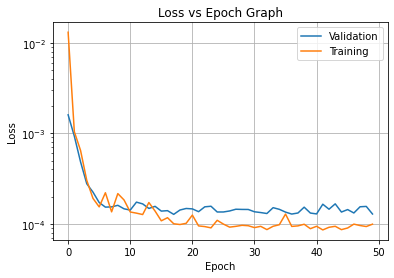

In [ ]:
import matplotlib.pyplot as plt

tr_loss = stat['tr_loss']
val_loss = stat['val_loss']
plt.semilogy(val_loss, label='Validation')
plt.semilogy(tr_loss, label='Training')
plt.legend()
plt.title('Loss vs Epoch Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('tr50epoch.eps', format='eps')
plt.show()

In [ ]:
### Upload model
model = IMU_Preprocess(param).to(param['device'])

model_ckp = torch.load("Training_Records/euroc/50_epoch_training_son/model_state.weights")
model.load_state_dict(model_ckp)

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

def eval_results(val_dataset):

  val_loader = DataLoader(
        val_dataset,
        batch_size=param["batch_size"],
        #sampler = valid_sampler,
        shuffle=False,
        num_workers=param["num_workers"],
        drop_last = True,
        pin_memory=True,
    )

  gamma_predict_list = []
  gt_gamma_list = []
  beta_predict_list = []
  gt_beta_list = []
  C_predict_list = []
  gt_C_list = []
  bias_gamma_list , bias_beta_list , bias_C_list = [[] for i in range(3)]

  with torch.no_grad():
    for i, (imu_data, gt_gamma, gt_beta, gt_C,  bias_gamma, bias_beta, bias_C) in enumerate(val_loader):
      imu_data = imu_data.type(torch.float32)
      gamma, beta, C, out = model(imu_data)

      gamma_predict_list.append(gamma.detach().numpy().flatten().reshape(-1,3))
      gt_gamma_list.append(gt_gamma.detach().numpy().flatten().reshape(-1,3))
      beta_predict_list.append(beta.detach().numpy().flatten().reshape(-1,3))
      gt_beta_list.append(gt_beta.detach().numpy().flatten().reshape(-1,3))
      C_predict_list.append(C.detach().numpy().flatten().reshape(-1,3))
      gt_C_list.append(gt_C.detach().numpy().flatten().reshape(-1,3))

  gamma_predict_list = np.array(gamma_predict_list).flatten().reshape(-1,3)
  gt_gamma_list = np.array(gt_gamma_list).flatten().reshape(-1,3)

  beta_predict_list = np.array(beta_predict_list).flatten().reshape(-1,3)
  gt_beta_list = np.array(gt_beta_list).flatten().reshape(-1,3)

  C_predict_list = np.array(C_predict_list).flatten().reshape(-1,3,3)
  gt_C_list = np.array(gt_C_list).flatten().reshape(-1,3,3)

  val_dataset.biased_integrations = []
  for i in range(len(val_dataset)):
    temp = val_dataset[i]

  pure_imu_int_gamma = []
  pure_imu_int_beta = []
  pure_imu_int_C = []
  for gamma_imu, beta_imu, C_imu in val_dataset.biased_integrations:
    pure_imu_int_gamma.append(gamma_imu)
    pure_imu_int_beta.append(beta_imu)
    pure_imu_int_C.append(C_imu)

  pure_imu_int_gamma = np.array(pure_imu_int_gamma)
  pure_imu_int_beta = np.array(pure_imu_int_beta)
  pure_imu_int_C = np.array(pure_imu_int_C)

  euler_predict_list = []
  euler_gt_list = []

  temp_C = np.eye(4)
  for (predicted_C, gtruth_C) in zip(C_predict_list, gt_C_list):
    temp_C[0:3,0:3] = predicted_C
    euler_predict_list.append(transformations.euler_from_matrix(temp_C))
    temp_C[0:3,0:3] = gtruth_C
    euler_gt_list.append(transformations.euler_from_matrix(temp_C))
  try:
    euler_predict_list = np.array(euler_predict_list)
    euler_gt_list = np.array(euler_gt_list)

    rmse_gamma= np.sqrt(np.mean(np.linalg.norm(gamma_predict_list - gt_gamma_list, axis = 1)))
    print("position error(RMSE):",rmse_gamma)

    rmse_beta = np.sqrt(np.mean(np.linalg.norm(beta_predict_list - gt_beta_list, axis = 1)))
    print("velocity error(RMSE):",rmse_beta)


    rmse_euler= np.sqrt(np.mean(np.linalg.norm(euler_predict_list - euler_gt_list, axis = 1)))
    print("angle error(RMSE):",rmse_euler)
  except:
    pass
  return [rmse_gamma, rmse_beta, rmse_euler]



In [ ]:
val_dataset_names = ["mh02", "mh04", "v103", "v202", "v101"]

sequence_lengths = [10,20,100]
pos_errors,  vel_errors, angle_errors = [[] for i in range(3)]
for seq_len in sequence_lengths:
  print("prediction time:", seq_len/200)
  param['seq_len'] = seq_len
  param['val_overlap'] = seq_len
  for val_ds in val_dataset_names:
    print(val_ds)
    val_dataset_x = IMU_Dataset(val_ds, param['seq_len'], param['val_overlap'])
    pos_error , vel_error, angle_error = eval_results(val_dataset_x)
    pos_errors.append(pos_error)
    vel_errors.append(vel_error)
    angle_errors.append(angle_error)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



prediction time: 0.05
mh02
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-552ee1fffd04>", line 11, in <module>
    val_dataset_x = IMU_Dataset(val_ds, param['seq_len'], param['val_overlap'])
  File "<ipython-input-2-8397b64a1e44>", line 16, in __init__
    self.base_path = os.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/I

FileNotFoundError: ignored